# $\fbox{$\textbf{DATALOADING WITH PYTORCH}$}$

This notebook follows introductory notebook `01-introduction-tutorial.ipynb`.

On top of providing a flexible automatic differentation, PyTorch provides additional features to make development easier for researcher. We will focus here on its dataloading features.


PyTorch offers a principled way to implement any dataloading pipeline, through efficient data access, transformation and batching. The latter revolves around the three following objects:
- `torch.utils.data.Dataset`: base class specifying access to data
- `Transforms`: unit preprocessing transformation applied on the fly to the data
- `torch.utils.data.DataLoader`: a dataset wrapper allowing efficient iteration

In [1]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import tqdm

---
# $\textbf{1 - The Dataset Class}$



In PyTorch, datasets are objects defining a procedure to access and load individual samples. This is particularly useful when working with massive amount of data we don't want to be loading in memory at once (when working with lightweight datasets, it's more efficient to load everything in memory).

They all inherit from abstract class `torch.utils.data.Dataset` and implement to two following python methods:

- `self.__getitem__(idx)`: defines how to query the sample indexed by value `idx`. The samples indexing needs to be defined by the user, typically in the `__init__` method. Once a `dataset` instance is created, this method is called by querying `dataset[idx]` as when indexing python lists.
- `self.__len__()`: returns the length of the dataset. Once a `dataset` instance is created, this method is called by querying `len(dataset)` as when working with python lists.


These fuzzy methods are called __magic methods__ and there are more of them that can be implemented as you see fit, [here](https://www.tutorialsteacher.com/python/magic-methods-in-python) for more infos.


Let's see how this work on a example. We propose to create a dataset to query the png images located in `data/identicons/`.

```
data
└── identicons
    ├── 000.png
    ├── 001.png
    ├── ...
    └── 127.png
```

We will open them with `PIL.Image`

In [2]:
class IdenticonDataset(torch.utils.data.Dataset):
    """Simple class defining procedure to load identicon pngs
    
    Args:
        root (str): root directory where pngs are stored
        
    Attributes:
        files_paths (list[str]): list of relative path to each png
    """
    def __init__(self, root):
        # Initialize list of relative path to each image
        self.files_paths = [os.path.join(root, file_name) for file_name in os.listdir(root)]
        
    def __getitem__(self, idx):
        # The input index can be used to index the list of paths
        file_path = self.files_paths[idx]
        
        # Load and return corresponding image
        img = Image.open(file_path)
        return img
    
    def __len__(self):
        # Length corresponds to total number of files
        return len(self.files_paths)

In [3]:
# Instantiate dataset
dataset = IdenticonDataset(root='./data/identicons')

# Verify length matches number of images in directory
len(dataset)

128

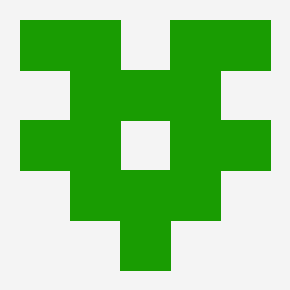

In [4]:
# Now you can query images directly by indexing the dataset
dataset[10]

---
# $\textbf{2 - Transformations}$

Data preprocessing is a major component of any ML pipeline. The above raw png images would typically need to be converted as tensors, normalized and maybe even undergo a couple of augmentation procedures.

With PyTorch, all of this can be specified within the `__getitem__` method such that preprocessing transforms are applied on the fly.

We will demonstrate it using image processing transformation implemented as part of PyTorch computer vision extension `torchvision`

In [5]:
class IdenticonDataset(torch.utils.data.Dataset):
    """Same class as above but we add a transformation step into it
    
    Args:
        root (str): root directory where pngs are stored
        transform (callable): a function that takes a single loaded 
            sample as an input and applies a preprocessing transform
        
    Attributes:
        files_paths (list[str]): list of relative path to each png
        transform (callable)
    """
    def __init__(self, root, transform):
        # Initialize list of relative path to each image
        self.files_paths = [os.path.join(root, file_name) for file_name in os.listdir(root)]
        
        # Set the transformation as an attribute to be able to call it later
        self.transform = transform
        
    def __getitem__(self, idx):
        # Load image corresponding to input idx
        file_path = self.files_paths[idx]
        img = Image.open(file_path)
        
        # Apply transform and return
        img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.files_paths)

We here use a transformation that successively takes:
- Random Vertical Flip of the image with probability `p=0.5`
- Random Crop of the image with cropped image size of `(200, 200)`
- Conversion from `PIL.Image` to PyTorch tensor

In [6]:
from torchvision import transforms

# Define transformation function as described above - this is a function
transform = transforms.Compose([transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomCrop(size=200),
                                transforms.ToTensor()])

# Instantiate dataset
dataset = IdenticonDataset(root='./data/identicons',
                           transform=transform)

In [7]:
# Verify properties of individual sample satisfy transform output
sample = dataset[0]
print("Sample type : ", type(sample))
print("Sample size after cropping : ", sample.shape)

Sample type :  <class 'torch.Tensor'>
Sample size after cropping :  torch.Size([3, 200, 200])


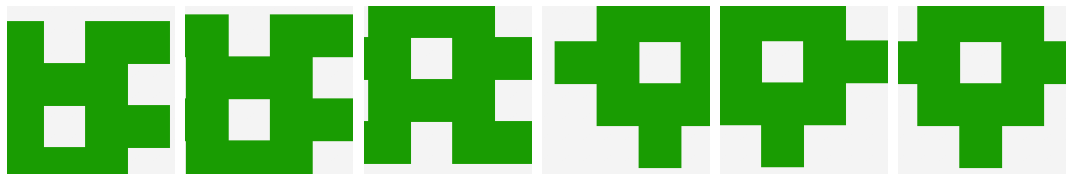

In [8]:
# Plot a couple of outputs when querying same image multiple time to show stochasticity
n_col = 6
idx = 10
fig, ax = plt.subplots(1, n_col, figsize=(15, 5))
for i in range(n_col):
    tensor = dataset[idx]
    ax[i].imshow(tensor.permute(1, 2, 0))
    ax[i].axis('off')
plt.tight_layout()

---
# $\textbf{3 - Iterating over dataset}$

So far, we've only demonstrated how to access and preprocess individual samples. In practice, it is common to iterate over __batches__ of samples when performing stochastic gradient approaches for example.

PyTorch proposes a very simple way to convert any dataset into an iterable with modular properties. Introducing the `torch.utils.data.DataLoader` wrapper, we can describe an iteration rationale which naturally integrates within training loops.


We here only present basic features of the dataloader, but interested reader can investigate more advanced features [here](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler).

In [9]:
from torch.utils.data import DataLoader

# Create a dataloader
dataloader = DataLoader(dataset=dataset,   # over previous dataset
                        batch_size=8,      # loading batches of 8 samples at once
                        shuffle=True,      # intially shuffling samples order
                        drop_last=True)    # drop last batch if dataset size isn't multiple of 8

Iteration then simply writes

```python
for batch in dataloader:
    # do your thing over batch
```

for example, here we plot successive batches

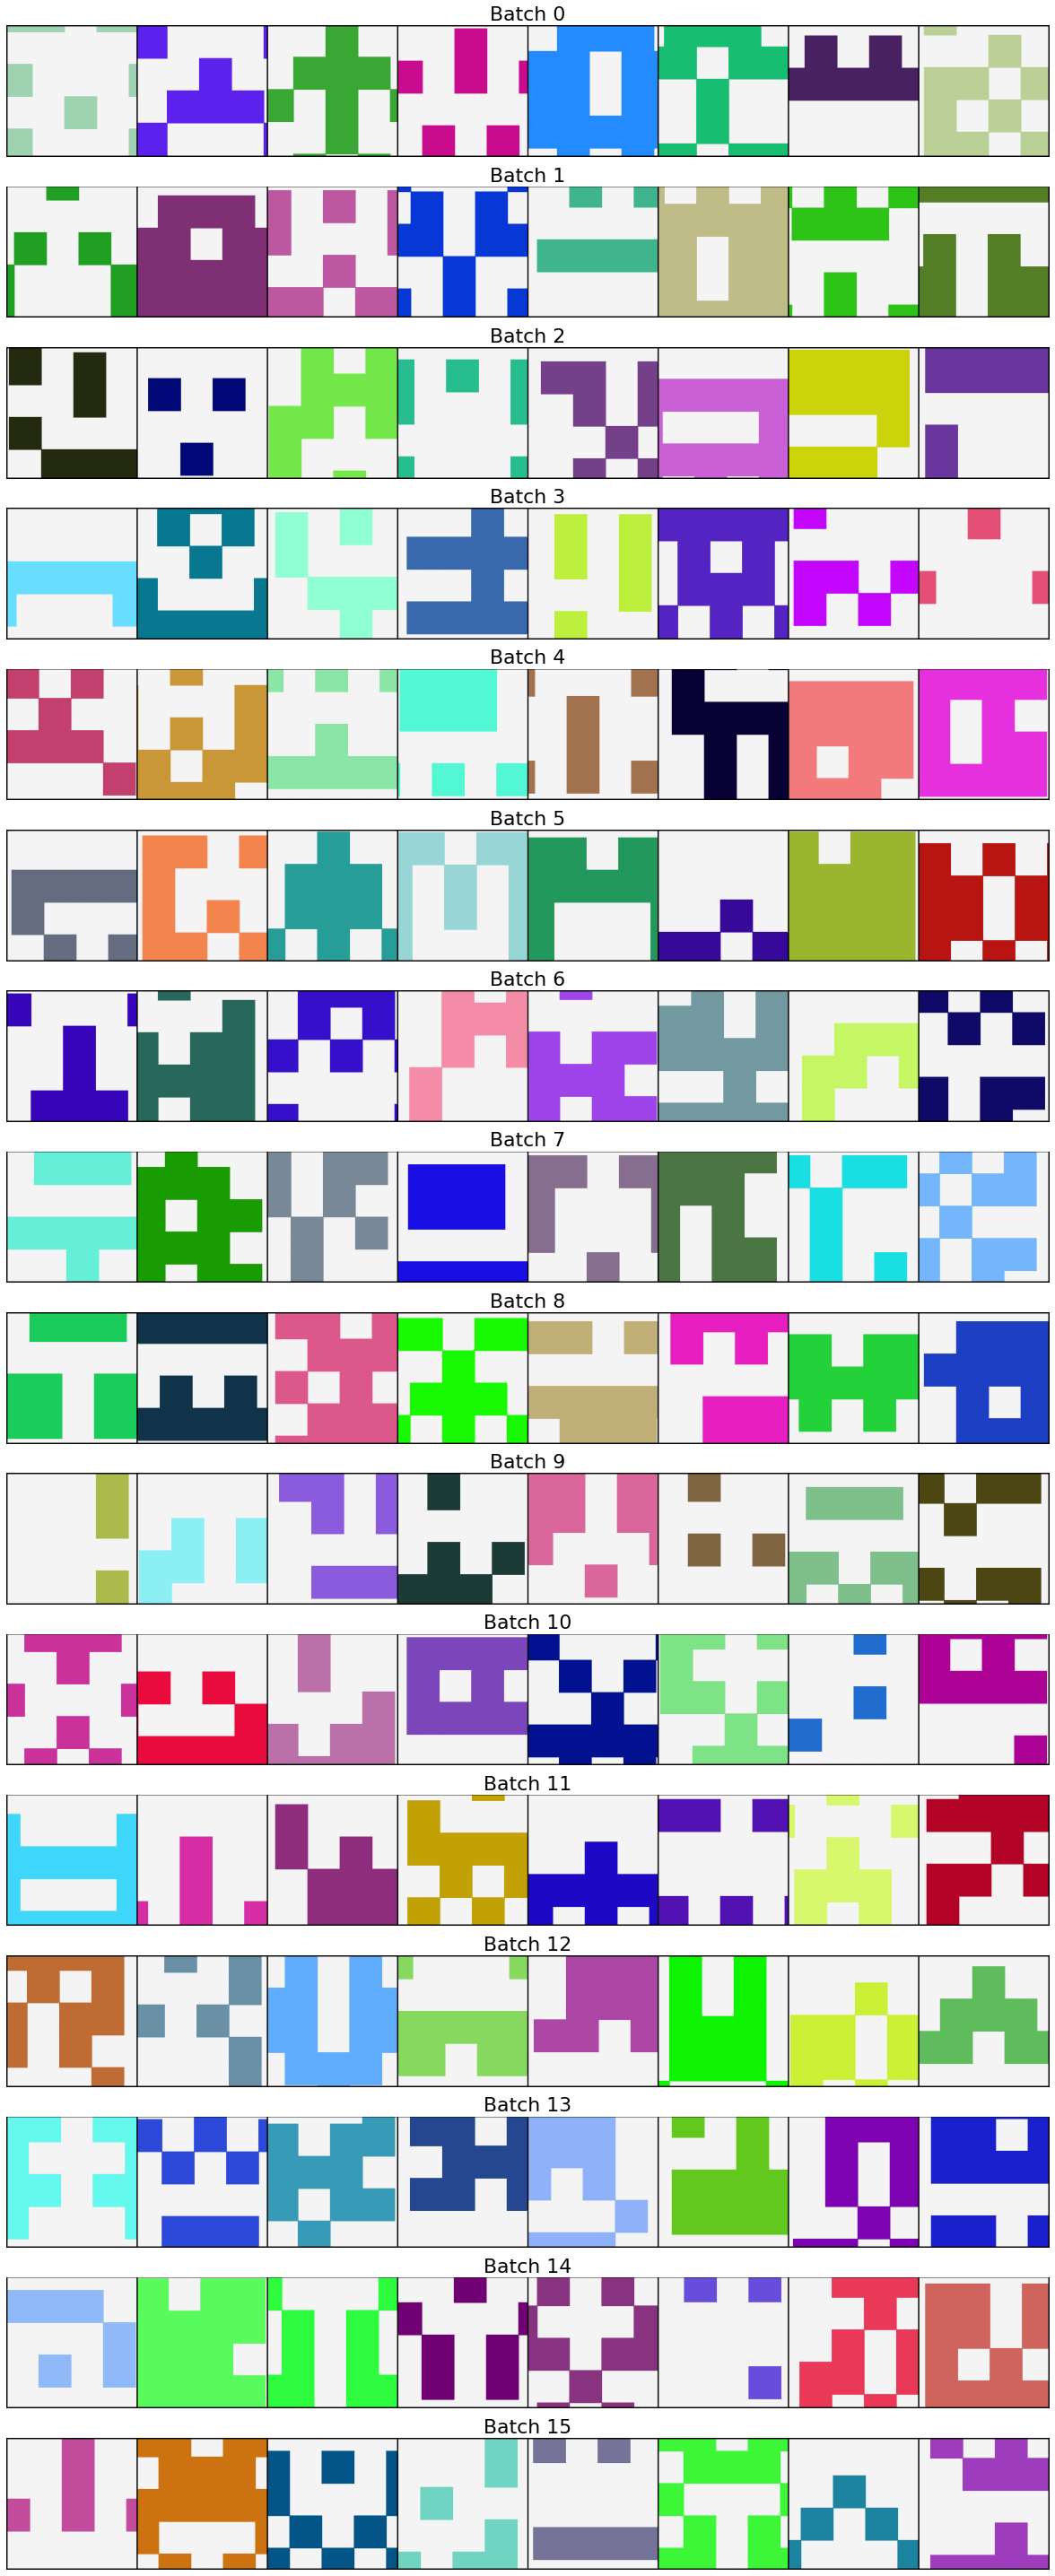

In [10]:
from torchvision.utils import make_grid

n_row = len(dataset) // 8

fig, ax = plt.subplots(n_row, 1, figsize=(5 * n_row, 5 * 8))
for i, batch in enumerate(dataloader):
    batch_img = make_grid(batch).permute(1, 2, 0)
    ax[i].imshow(batch_img)
    ax[i].axis('off')
    ax[i].set_title(f"Batch {i}", fontsize=22)
    
plt.tight_layout()
plt.show()